In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

SIZE = 256

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name, 1)  # Change 0 to 1 for color images
        image = cv2.resize(image, (SIZE, SIZE))
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Load images
image_dir = '/data1/sprasad/data/unlabeled'
dataset = ImageDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

img_data = []
for img in tqdm(dataloader):
    img_data.append(img.numpy())

img_array = np.concatenate(img_data, axis=0)
img_array = img_array.astype('float32') / 255.
img_array=torch.tensor(img_array).float()

# # In the interest of time let us train on 500 images
# img_array2 = torch.tensor(img_array[200:700]).float()

/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 4488/4488 [00:51<00:00, 86.61it/s]


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels, out_channels)
        
    def forward(self, x):
        x = self.upconv(x)
        x = self.conv(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels):
        super(Encoder, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.bridge = ConvBlock(512, 1024)
        
    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)
        b = self.bridge(p4)
        return s1, s2, s3, s4, b

class AutoencoderDecoder(nn.Module):
    def __init__(self, out_channels):
        super(AutoencoderDecoder, self).__init__()
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = torch.sigmoid(self.output(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = AutoencoderDecoder(out_channels)
        
    def forward(self, x):
        _, _, _, _, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [4]:
# import torch.optim as optim

# # Hyperparameters
# epochs = 800
# learning_rate = 1e-3



# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# # Training loop
# autoencoder.train()
# for epoch in range(epochs):
#     epoch_loss = 0
#     for img in tqdm(img_array):
#         img = img.to(device)
#         optimizer.zero_grad()
#         output = autoencoder(img.unsqueeze(0))
#         loss = criterion(output, img.unsqueeze(0))
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(img_array)}')
#     torch.save(autoencoder.state_dict(),f'auto_encoder_wts/pretrained_wt_unet_model_epoch_{epoch+1}.pth')
    
# # Save the model

# Initialize the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder(in_channels=3, out_channels=3).to(device)

In [7]:
# Load the model
autoencoder.load_state_dict(torch.load('auto_encoder_wts/pretrained_wt_unet_model_epoch_114.pth'))
autoencoder.eval()

Autoencoder(
  (encoder): Encoder(
    (enc1): EncoderBlock(
      (conv): ConvBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc2): EncoderBlock(
      (conv): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=

In [11]:


# Test on a few images
num = np.random.randint(0, len(img_array))
test_img = img_array[num]
test_img_tensor = torch.tensor(test_img).float().unsqueeze(0).to(device)
with torch.no_grad():
    pred = autoencoder(test_img_tensor)



/tmp/ipykernel_3114068/3812214386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_img_tensor = torch.tensor(test_img).float().unsqueeze(0).to(device)


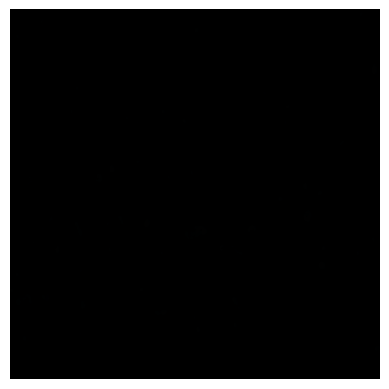

In [23]:
# If 'pred' is on GPU, move it to CPU
pred_cpu = pred.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot the image
plt.imshow(pred_cpu)
plt.axis('off')  # Hide the axes
plt.show()

In [18]:
test_img_tensor.shape

torch.Size([1, 3, 256, 256])

In [ ]:
# Plot the original and reconstructed images
plt.subplot(1, 2, 1)
plt.imshow(test_img.transpose(1, 2, 0)*255)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(pred.cpu().numpy()[0].transpose(1, 2, 0))
plt.title('Reconstructed')
plt.show()
